In [1]:
"""
Notes:
fnlwgt is sort of a numerical estimate to how similar a person is to another. The closer they are demographically,
the closer their fnlwgt score is. This is taken from the adult.names file, "People with similar demographic
characteristics should have similar weights."
"""

'\nNotes:\nfnlwgt is sort of a numerical estimate to how similar a person is to another. The closer they are demographically,\nthe closer their fnlwgt score is. This is taken from the adult.names file, "People with similar demographic\ncharacteristics should have similar weights."\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [15]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'martial-status', 'occupation', 'relationship', 'race',
                'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                'native-country', 'label']

train_df = pd.read_csv('adult.data',names = cols,index_col = False, skipinitialspace=True)
test_df = pd.read_csv('adult.test',names = cols,index_col = False, skiprows = 1, skipinitialspace=True)

In [16]:
# Data cleaning:
# education num is a label encoding, we want to do one-hot so we drop education-num
train_df = train_df.drop('education-num', axis='columns')
test_df = test_df.drop('education-num', axis='columns')

# drop all rows with unknown values
def clear_unknown_rows(df):
    df = df.replace('?',np.NaN)
    # existed in test but not training set, can do this in a better way but skipping for now
    df = df.replace('Holand-Netherlands', np.NaN)
    df = df.dropna()
    return df

train_df = clear_unknown_rows(train_df)
test_df = clear_unknown_rows(test_df)
combined_df = pd.concat([test_df,train_df])

In [17]:
# Preliminary charts (finding common attributes that people making under 50K have)
combined_df.head()
combined_df.replace({'<=50K.': 0, '>50K.' : 1, '<=50K': 0, '>50K' : 1}, inplace=True)
under_50_df = combined_df.loc[combined_df['label'] == 0]
under_50_df

,age,workclass,fnlwgt,education,martial-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
5,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0
8,24,Private,369667,Some-college,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,0
9,55,Private,104996,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,32,Private,116138,Masters,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,0
32555,22,Private,310152,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0
32556,27,Private,257302,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32558,58,Private,151910,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0


In [18]:
# one hot encoding - added prefix to columns so that we can consolidate them later
def encode_categories(df):
    df = df.join(pd.get_dummies(df.pop('workclass'), prefix='workclass'))
    df = df.join(pd.get_dummies(df.pop('education'), prefix='education'))
    df = df.join(pd.get_dummies(df.pop('martial-status'), prefix='martial-status'))
    df = df.join(pd.get_dummies(df.pop('occupation'), prefix='occupation'))
    df = df.join(pd.get_dummies(df.pop('relationship'), prefix='relationship'))
    df = df.join(pd.get_dummies(df.pop('race'), prefix='race' ))
    df = df.join(pd.get_dummies(df.pop('sex'), prefix='sex'))
    df = df.join(pd.get_dummies(df.pop('native-country'), prefix='native-country'))
    # label needs to be one column instead of two
    # need 4 because there's one with a period and one without
    df.replace({'<=50K.': 0, '>50K.' : 1, '<=50K': 0, '>50K' : 1}, inplace=True)
    return df

numerical_df = train_df.copy()
numerical_df.replace({'<=50K.': 0, '>50K.' : 1, '<=50K': 0, '>50K' : 1}, inplace=True)

train_df = encode_categories(train_df)
test_df = encode_categories(test_df)

In [19]:
# last step is to get the labels from the training set
train_labels_df = train_df['label']
test_labels_df = test_df['label']
train_df = train_df.drop(['label'],axis=1)
test_df = test_df.drop(['label'],axis=1)

In [20]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=250, max_depth=8)
clf.fit(train_df,train_labels_df)
y_pred=clf.predict(test_df)

print("Accuracy:", metrics.accuracy_score(test_labels_df,y_pred))

Accuracy: 0.850265604249668


In [9]:
# importance = clf.feature_importances_
# names = train_df.columns
# model_type = 'Random Forest'
# Importance is feature importance values
# Names is Column names
# model_type is a string describing the model
# topfeatures is the top number features you want to plt
def plot_feature_importance(importance, names, model_type, topfeatures, encoded_categories):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_name': feature_names, 'feature_importance': feature_importance}
        
    FI_df = pd.DataFrame(data)
    for category in encoded_categories:
        this_category = FI_df.loc[FI_df['feature_name'].str.startswith(category)]
        this_category_importance = this_category['feature_importance'].sum(axis=0)
        FI_df = FI_df[~FI_df.feature_name.isin(this_category.feature_name)]
        FI_df = FI_df.append({'feature_name': category, 'feature_importance': this_category_importance}, ignore_index=True)
    
    # Sort DF in terms of feature importance
    FI_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    # Font 
    font = {'fontname': 'Georgia'}
    
    
    
    #Plot Feature Importance Bar Chart
    plt.figure(figsize = (5,5))
    sns.barplot(x = FI_df['feature_importance'][:topfeatures], y = FI_df['feature_name'][:topfeatures])
    # Add chart labels
#     for index, value in enumerate(feature_importance[:topfeatures]):
#         plt.text(value + 0.01, index, str(value), color = 'black', **font)
    
    plt.title(model_type + ' Feature Importance',**font,fontsize = 20,fontweight="bold")
    plt.xlabel('Feature Importance',**font,fontsize = 15,fontweight="bold")
    plt.ylabel('Feature Names',**font,fontsize = 15,fontweight="bold")
    plt.xticks(**font)
    plt.yticks(**font)

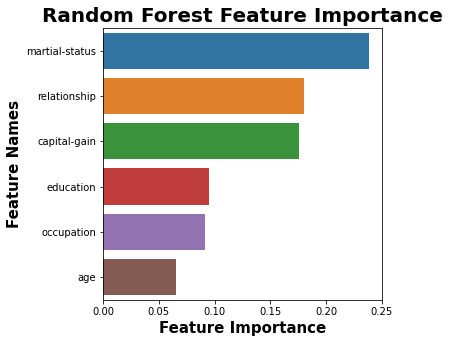

In [13]:
encoded_categories = ('workclass', 'education', 'martial-status', 'occupation', 'relationship',
                      'race', 'sex', 'native-country')
plot_feature_importance(clf.feature_importances_, train_df.columns, 'Random Forest', 6, encoded_categories)

In [287]:
abs_corr_coeffs = numerical_df.corr()['label'].abs().sort_values()
print(abs_corr_coeffs)

fnlwgt            0.008987
capital-loss      0.150222
capital-gain      0.221195
hours-per-week    0.229480
age               0.241991
label             1.000000
Name: label, dtype: float64


In [288]:
Feature_Series= numerical_df['age']
Label_Series = numerical_df['label']

Age_Label_df = pd.concat([Feature_Series,Label_Series], axis = 1)

In [289]:
def stacked_bar_f(column):
    x = numerical_df[column]

    x1 = x[numerical_df['label']==1]
    #x2 = x[Age_Label_df['label']==0]

    label1 = ['Total People in' + column + 'Group']
    label2 = ['Percentage with $50K+ Salary']

    plt.figure()
    plt.hist(x , bins = 7 ,rwidth = 0.7 , stacked = True, ec = 'k',label = label1)
    plt.hist(x1 ,bins = 7, rwidth = 0.7, stacked = True, ec = 'k',label = label2)
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title( column +'vs Income')
    plt.legend()
    return plt.show()

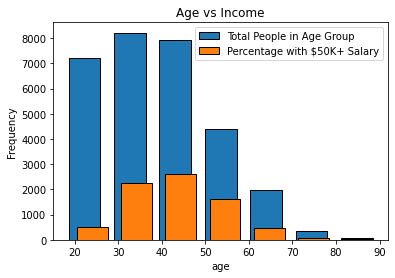

In [290]:
x = Age_Label_df['age']

x1 = x[Age_Label_df['label']==1]
x2 = x[Age_Label_df['label']==0]

label1 = ['Total People in Age Group']
label2 = ['Percentage with $50K+ Salary']

plt.figure()
plt.hist(x , bins = 7 ,rwidth = 0.7 , stacked = True, ec = 'k',label = label1)
plt.hist(x1 ,bins = 7, rwidth = 0.7, stacked = True, ec = 'k',label = label2)


plt.xlabel('age')
plt.ylabel('Frequency')
plt.title('Age vs Income')
plt.legend()

In [291]:
corr_df = abs_corr_coeffs.to_frame(name = '50K+ Salary Correlation')
corr_df = corr_df.reset_index()[:-1]
corr_df.columns = ['Features','50K+ Salary Correlation']

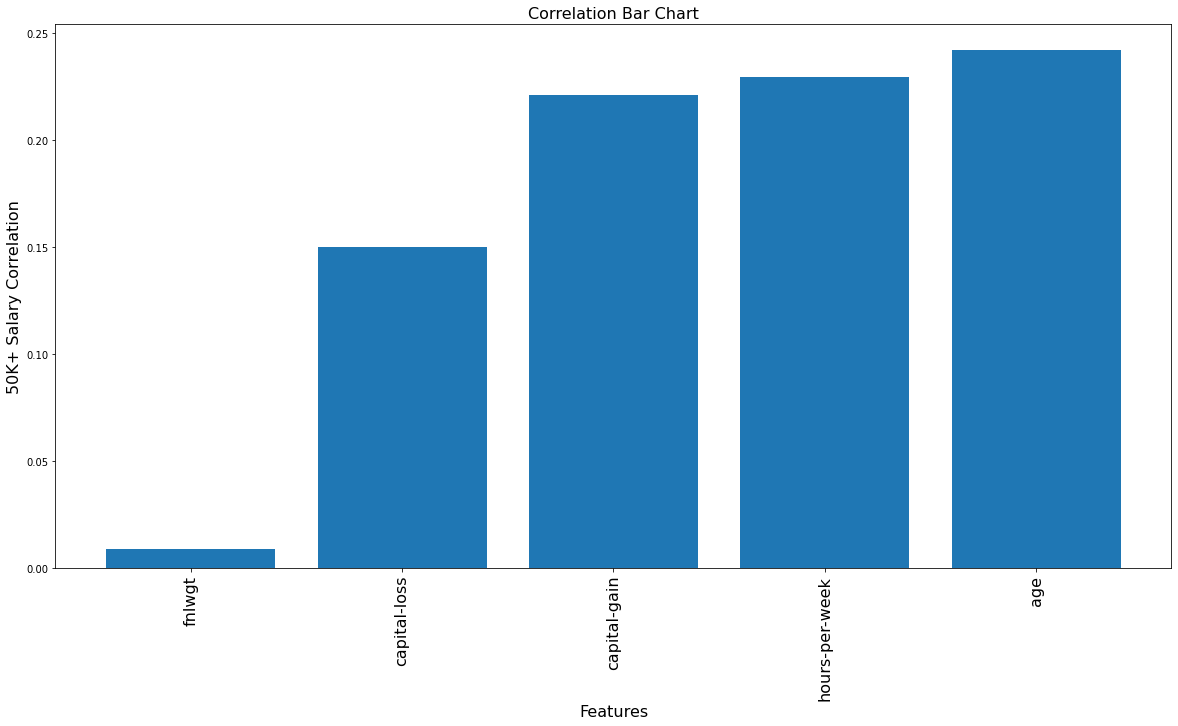

In [292]:
%matplotlib inline

feats = corr_df['Features']
sal_cor = corr_df['50K+ Salary Correlation']


plt.figure(figsize = (20,10))
plt.bar(x = feats, height = sal_cor)
plt.xticks(rotation = 90, fontsize=16)
plt.xlabel('Features',fontsize=16)
plt.ylabel('50K+ Salary Correlation',fontsize=16)
plt.title('Correlation Bar Chart', fontsize=16)
plt.show()